In [80]:
import pandas as pd
import sqlite3
import re
import string
import numpy as np
from sklearn.feature_extraction import stop_words
from collections import Counter
from wordcloud import WordCloud
import unicodedata
import os
import spacy
nlp = spacy.load("en_core_web_sm")

In [81]:
# this only needs to be run once
%load_ext rpy2.ipython

# load ggplot2
%R library(ggplot2)
%R library(scales)
%R library(ggwordcloud)
%R library(png)
%R library(grid)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['grid', 'png', 'ggwordcloud', 'scales', 'ggplot2', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U11')

In [82]:
def words(text):
    """
    Given a string, return a list of words normalized as follows.
    Split the string to make words first by using regex compile() function
    and string.punctuation + '0-9\\r\\t\\n]' to replace all those
    char with a space character.
    Split on space to get word list.
    Ignore words < 3 char long.
    Lowercase all words
    Remove English stop words
    """

    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    words = text.split(' ')
    words = [w for w in words if len(w) >= 3]  # ignore a, an, to, at, be, ...
    words = [w for w in words if w not in stop_words.ENGLISH_STOP_WORDS]

    return words

### Read Data

In [83]:
df_content = pd.read_csv(os.path.join('data','df_content.csv'))

### Create word count dfs

In [84]:
s_all_reviews = ''
for rev in df_content['content'].values:
    s_all_reviews += str(rev)

# remove weird x06 type stuff
new_str = unicodedata.normalize("NFKD", s_all_reviews)

# get list of words
w = words(new_str)

# get word count
word_counts = Counter(w)

In [85]:
# create word count df
df_word_counts = pd.DataFrame.from_dict(dict(word_counts), orient='index').reset_index()
df_word_counts.columns = ['word','count']

# filter df to show in wordcloud
df_wc_filt = df_word_counts.loc[df_word_counts['count']>3000].copy()
df_wc_filt.shape

(248, 2)

### Wordcloud of all words

In [86]:
%R -i df_wc_filt

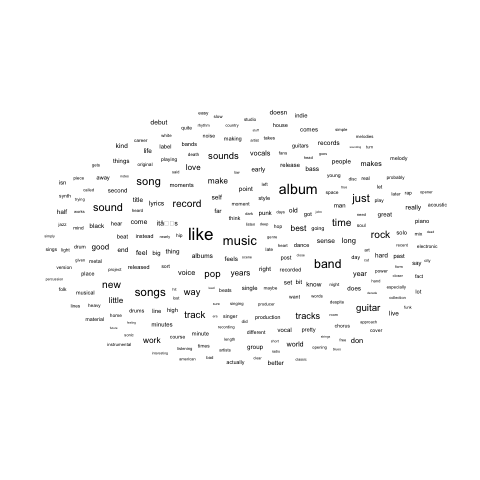

In [87]:
%%R

(ggplot()
+ geom_text_wordcloud(aes(label=word, size=count), df_wc_filt)
+ theme_void())

Not informative. Let's try adjectives.

### NLP Attempt

In [88]:
len(w)

6390240

In [89]:
len(set(w))

155500

In [90]:
s = ' '.join(set(w))

In [91]:
nlp.max_length = 1500000
doc = nlp(s)

In [92]:
winfo = []
for token in doc:
    winfo.append([token.text, token.pos_, token.is_stop])
    
df_nlp = pd.DataFrame(data=winfo, columns=['word','part of speech', 'stop word'])
df_nlp.head(2)

,word,part of speech,stop word
0,headrobes,NOUN,False
1,gunfight,ADJ,False


In [93]:
df_nlp['word_len'] = df_nlp['word'].str.len()
df_adj = df_nlp.loc[df_nlp['part of speech']=='ADJ'].drop_duplicates().reset_index(drop=True).copy()

In [94]:
df_adj_count = pd.merge(df_adj,
         df_word_counts,
         on='word')
df_adj_count.head(2)

,word,part of speech,stop word,word_len,count
0,gunfight,ADJ,False,8,9
1,skiffley,ADJ,False,8,1


In [95]:
df_adj_count_filt = df_adj_count.loc[(df_adj_count['count']>500) & (df_adj_count['word_len']>5)]
df_adj_count_filt.shape

(327, 5)

In [96]:
df_obscure = df_adj_count.loc[(df_adj_count['count']>3) & (df_adj_count['word_len']>13)].sort_values(by='count',ascending=False)
df_obscure.shape

(172, 5)

In [97]:
ls_highlight = ['quintessential', 'transcendental', 'phosphorescent', 'deconstructive', 'extemporaneous']
df_obscure['highlight'] = 'no'
df_obscure.loc[df_obscure['word'].isin(ls_highlight),'highlight'] = 'yes'

In [98]:
df_obscure.loc[df_obscure['word'].str.startswith('dec')]

,word,part of speech,stop word,word_len,count,highlight
242,deconstructive,ADJ,False,14,23,yes


In [99]:
df_obscure.head()

,word,part of speech,stop word,word_len,count,highlight
5488,straightforward,ADJ,False,15,1145,no
16288,aforementioned,ADJ,False,14,696,no
14104,instrumentalist,ADJ,False,15,379,no
2184,confrontational,ADJ,False,15,253,no
8130,characteristic,ADJ,False,14,249,no


### Wordcloud of adjectives

In [100]:
%R -i df_adj_count_filt
%R -i df_obscure

In [101]:
# %%R -w 6 -h 4.5 --units in -r 300
%%R

wordcloud <- (ggplot()
+ geom_text_wordcloud(aes(label=word, size=count, color=highlight), 
                      df_obscure)
+ scale_colour_manual(values=c('black','dodgerblue2'))
+ theme_void())
print(wordcloud)

UsageError: Line magic function `%%R` not found.
